In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=6, processes=6,  walltime='04:00:00')
w = cluster.scale(12*6)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.36.179:40970 Dashboard: /user/yux/proxy/8787/status,Cluster Workers: 72 Cores: 72 Memory: 1.20 TB


__________
# Ratio maps

In [5]:
#grd = load_grd(ftype='nc').reset_coords()
dij = 4
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
grd_rspec_dij = grd_rspec.isel(i=slice(0,None,dij), j=slice(0,None,dij))

print(grd_rspec_dij)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>


In [6]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/hourly_rms/'
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [7]:
ds = xr.concat([xr.open_zarr(E_dir+'rms_acceleration_2hours_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
ds = ds.assign_coords(**grd_rspec_dij)
acceleration_2hours = ds.uv_t
acceleration_2hours

<xarray.DataArray 'uv_t' (face: 13, j: 1080, i: 1080)>
dask.array<concatenate, shape=(13, 1080, 1080), dtype=float32, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    mask     (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [8]:
ds = xr.concat([xr.open_zarr(E_dir+'rms_acceleration_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
ds = ds.assign_coords(**grd_rspec_dij)
acceleration = ds.acceleration

ds = xr.concat([xr.open_zarr(E_dir+'rms_nolinear_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
nonlinear = ds.nolinear

ds = xr.concat([xr.open_zarr(E_dir+'rms_fuv_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
linear_corilis = ds.rms_fuv

ds = xr.concat([xr.open_zarr(E_dir+'rms_pressure_gradient_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
pressure_gradient = ds.rms_pressure_gradient

ds = xr.concat([xr.open_zarr(E_dir+'rms_fuv_a_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
f_ageo = ds.rms_fuv_a

ds = xr.concat([xr.open_zarr(E_dir+'rms_residuals_f%02d.zarr'%(face)) for face in F], dim='face', compat='identical')
residuals = ds.residuals

Tau_ELD = xr.open_dataset('/work/ALT/swot/aval/syn/xy/momentum_balance/data/Tau_ELD_rms.nc')
Tau_ELD_rms = Tau_ELD.Tau_ELD_rms

In [9]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

In [47]:
font_size = 28

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='110m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        #cmap=plt.cm.get_cmap('Greens_r', 10)
        cmap=plt.cm.get_cmap('RdBu_r', 10)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
        ax.set_ylim(-60., 60.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [48]:
plot_pretty(acceleration.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500)  & (f_ageo.j!=40) )/f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500) ), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_11a_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [49]:
plot_pretty(nonlinear.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500) )/f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500) & (f_ageo.j!=40) ), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_11b_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [50]:
plot_pretty(residuals.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500) )/f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500) & (f_ageo.j!=40)), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6], savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_11c_dpi180.png')

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

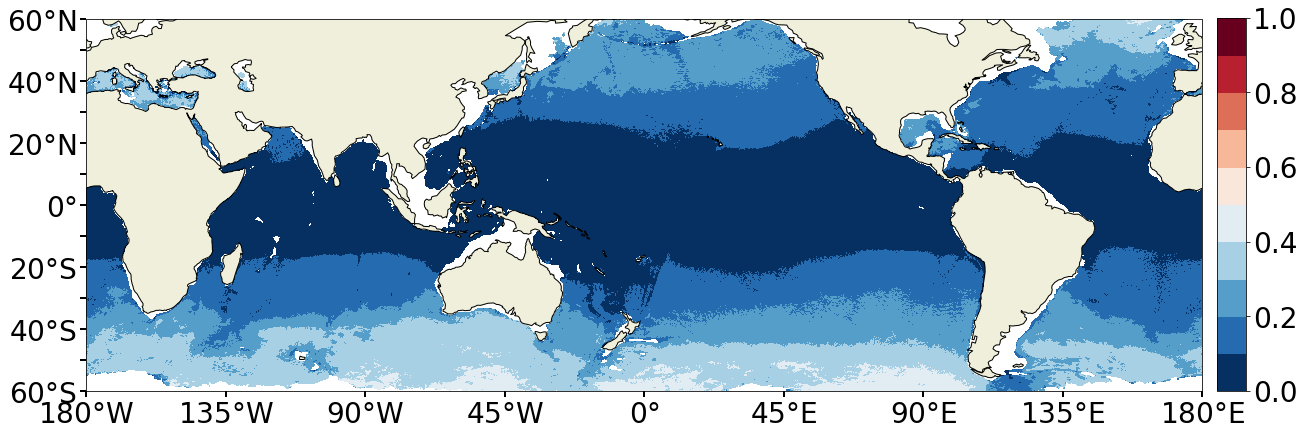

In [20]:
plot_pretty(Tau_ELD_rms.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500) )/f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where( (ice>0) & (f_ageo.Depth>500) & (f_ageo.j!=40) ), label='', vmin=0, vmax=1, cmmap='Greens_r', ignore_face=[6])

## Zonally averaged Ratio

In [ ]:
deep_depth = 2000

accerlation_normalised = (acceleration.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
accerlation_normalised_zonmean = (accerlation_normalised.where(accerlation_normalised.Depth>deep_depth).groupby_bins(accerlation_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

nonlinear_advection_normalised = (nonlinear.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
nonlinear_advection_normalised_zonmean = (nonlinear_advection_normalised.where(nonlinear_advection_normalised.Depth>deep_depth).groupby_bins(nonlinear_advection_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

Tau_ELD_normalised = (Tau_ELD.where(ice>0)/2/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
Tau_ELD_normalised_zonmean = (Tau_ELD_normalised.where(Tau_ELD_normalised.Depth>deep_depth).groupby_bins(Tau_ELD_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

R_normalised = (residuals.where(ice>0)/f_ageo.where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
R_normalised_zonmean = (R_normalised.where(R_normalised.Depth>deep_depth).groupby_bins(R_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

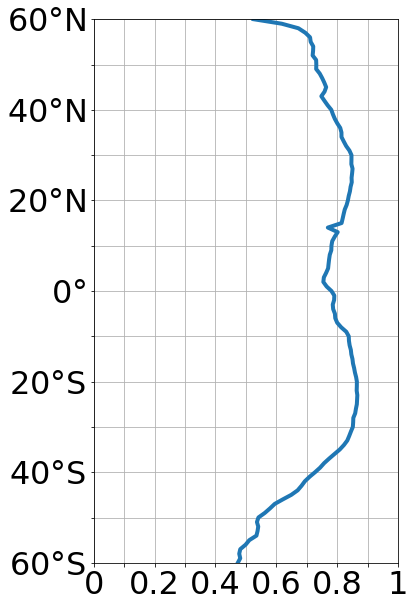

In [12]:
font_size=32

fig, ax = plt.subplots(figsize=(12,10))

ax = plt.subplot(121)
accerlation_normalised_zonmean.plot(y='YC_bins',label=r'$\frac{\langle D \vec{u}/D t \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_ylim(-60, 60)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.set_xlim([0,1])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_xticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1'])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_11d.png')

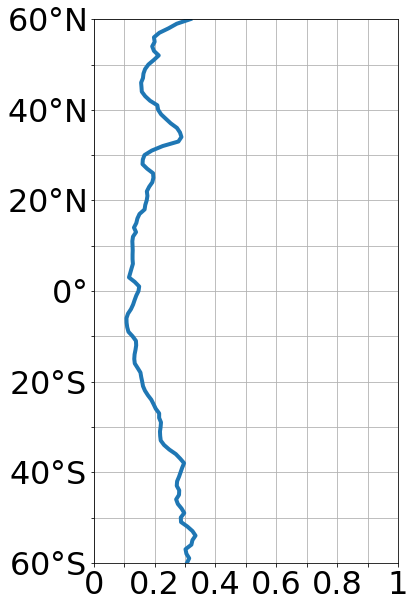

In [13]:
font_size=32

fig, ax = plt.subplots(figsize=(12,10))

ax = plt.subplot(121)
nonlinear_advection_normalised_zonmean.where(np.isfinite(nonlinear_advection_normalised_zonmean), drop=True).plot(y='YC_bins',label=r'$\frac{\langle D \vec{u}/D t \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=4) # total energy
#ax.legend(prop={'size': 36}); 
ax.grid()
# x,y ticks
ax.set_ylim(-60, 60)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.set_xlim([0,1])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_xticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1'])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_11e.png')

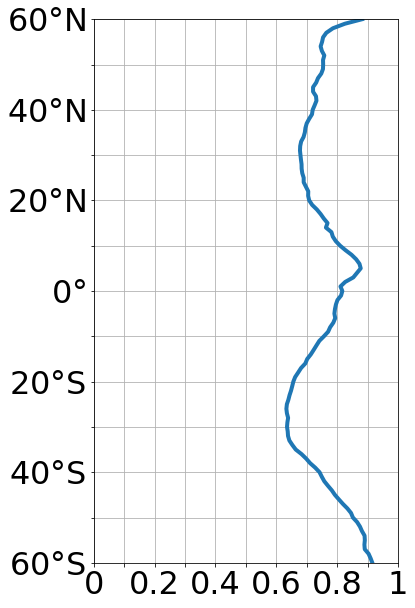

In [14]:
font_size=32

fig, ax = plt.subplots(figsize=(12,10))

ax = plt.subplot(121)
R_normalised_zonmean.where(np.isfinite(R_normalised_zonmean), drop=True).plot(y='YC_bins',label=r'$\frac{\langle \vec{R} \rangle_{rms}}{\langle f \times \vec{u}_a \rangle_{rms}}$', linewidth=4) # total energy
#ax.legend(prop={'size': 36}); 
ax.grid()
# x,y ticks
ax.set_ylim(-60, 60)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.set_xlim([0,1])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_xticklabels(['0','','0.2','','0.4','','0.6','','0.8','','1'])
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_11f.png')

# Zonal mean RMS

In [12]:
E_dir = '/work/ALT/swot/aval/syn/xy/momentum_balance/hourly_rms/'

ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [30]:
deep_depth = 2000

accerlation_normalised = (acceleration.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
accerlation_normalised_zonmean = (accerlation_normalised.where(accerlation_normalised.Depth>deep_depth).groupby_bins(accerlation_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

f_ageo_normalised = (f_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
f_ageo_zonmean = (f_ageo_normalised.where(f_ageo_normalised.Depth>deep_depth).groupby_bins(f_ageo_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

linear_corilis_normalised = (linear_corilis.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
linear_corilis_zonmean = (linear_corilis_normalised.where(linear_corilis_normalised.Depth>deep_depth).groupby_bins(linear_corilis_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

pressure_gradient_normalised = (pressure_gradient.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
pressure_gradient_zonmean = (pressure_gradient_normalised.where(pressure_gradient_normalised.Depth>deep_depth).groupby_bins(pressure_gradient_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

nonlinear_advection_normalised = (nonlinear.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
nonlinear_advection_normalised_zonmean = (nonlinear_advection_normalised.where(nonlinear_advection_normalised.Depth>deep_depth).groupby_bins(nonlinear_advection_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

residuals_normalised = (residuals.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
residuals_normalised_zonmean = (residuals_normalised.where(residuals_normalised.Depth>deep_depth).groupby_bins(residuals_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

In [33]:
deep_depth = 2000

accerlation_normalised = (acceleration_2hours.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
accerlation_normalised_zonmean_2hours = (accerlation_normalised.where(accerlation_normalised.Depth>deep_depth).groupby_bins(accerlation_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

In [31]:
deep_depth = 2000

# Vertical stress divergence term from datarmor
Tau_ELD = xr.open_dataset('/work/ALT/swot/aval/syn/xy/momentum_balance/data/Tau_ELD_rms.nc')
Tau_ELD_rms = Tau_ELD.Tau_ELD_rms
Tau_ELD_rms

Tau_ELD_normalised = (Tau_ELD_rms.isel(i=slice(1,-1),j=slice(1,-1)).where(ice>0)).stack(point=['face','j', 'i']).chunk({'point': 100000})
Tau_ELD_normalised_zonmean = (Tau_ELD_normalised.where(Tau_ELD_normalised.Depth>deep_depth).groupby_bins(Tau_ELD_normalised['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))

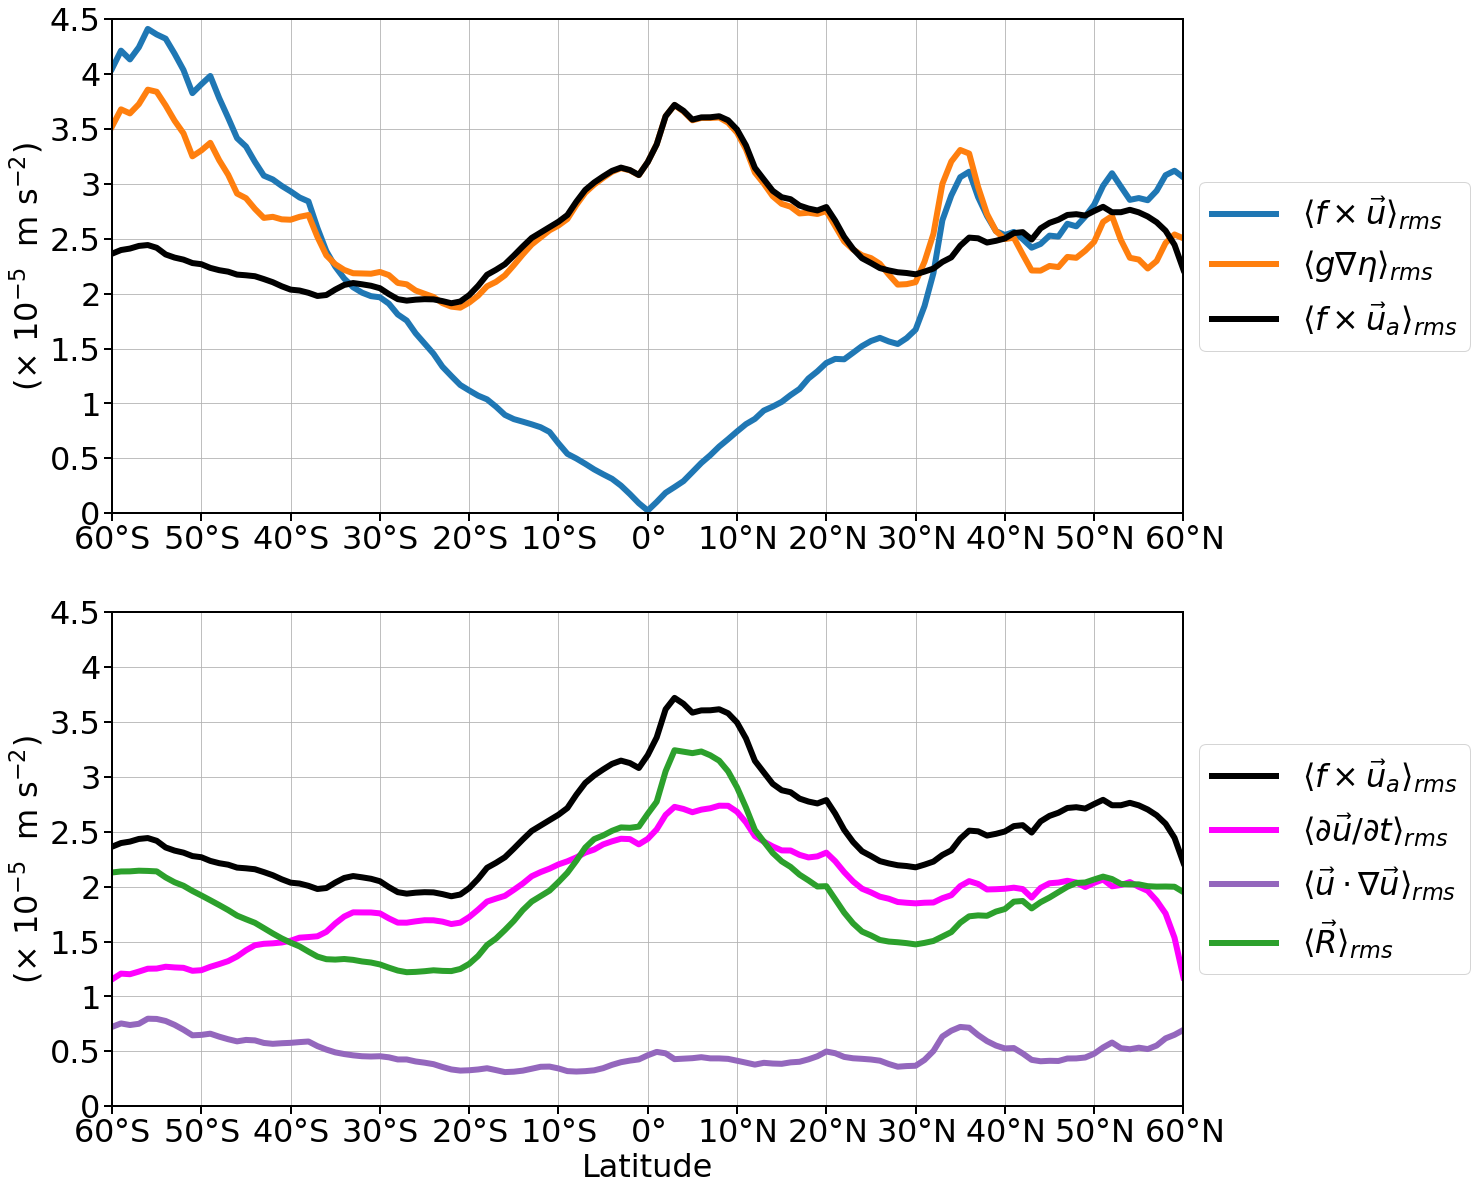

In [27]:
font_size=32
linewidth=6

fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(211)
linear_corilis_zonmean.plot(label=r'$\langle f \times \vec{u} \rangle_{rms}$', linewidth=linewidth, color="tab:blue") 
pressure_gradient_zonmean.where(np.isfinite(pressure_gradient_zonmean), drop=True).plot(label=r'$\langle g\nabla\eta \rangle_{rms}$', linewidth=linewidth, color="tab:orange") 
f_ageo_zonmean.where(np.isfinite(f_ageo_zonmean), drop=True).plot(label=r'$\langle f \times \vec{u}_a \rangle_{rms}$', linewidth=linewidth, color="black") 
ax.grid()
# x,y ticks
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50,60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_ylim([0,4.5e-5])
#ax.set_yticks([0,1e-5,2e-5,3e-5,4e-5,5e-5])
ax.set_yticks([0,0.5e-5,1e-5,1.5e-5,2e-5,2.5e-5,3e-5,3.5e-5,4e-5,4.5e-5])
ax.set_yticklabels(['0','0.5','1','1.5','2','2.5','3','3.5','4','4.5'])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel(r'($\times$ 10$^{-5}$  m s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


ax = plt.subplot(212)
f_ageo_zonmean.where(np.isfinite(f_ageo_zonmean), drop=True).plot(label=r'$\langle f \times \vec{u}_a \rangle_{rms}$', linewidth=linewidth, color="black") 
accerlation_normalised_zonmean.plot(label=r'$\langle \partial \vec{u}/\partial t \rangle_{rms}$', linewidth=linewidth, color="magenta") 
nonlinear_advection_normalised_zonmean.where(np.isfinite(nonlinear_advection_normalised_zonmean), drop=True).plot(label=r'$\langle \vec{u} \cdot \nabla \vec{u} \rangle_{rms}$', linewidth=linewidth, color="tab:purple") 
residuals_normalised_zonmean.where(np.isfinite(residuals_normalised_zonmean), drop=True).plot(label=r'$\langle \vec{R}  \rangle_{rms}$', linewidth=linewidth, color="tab:green") 
#(Tau_ELD_normalised_zonmean).plot(label=r'$\langle \vec{F}  \rangle_{rms}$', linewidth=linewidth, color="magenta") 
#(accerlation_normalised_zonmean+nonlinear_advection_normalised_zonmean+residuals_normalised_zonmean).plot(label=r'$\langle \partial \vec{u}/\partial t \rangle_{rms} +  \langle \vec{u} \cdot \nabla \vec{u} \rangle_{rms} + \langle \vec{F}  \rangle_{rms}$', linewidth=linewidth, color="magenta") 
ax.grid()
# x,y ticks
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50,60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_ylim([0,4.5e-5])
#ax.set_yticks([0,1e-5,2e-5,3e-5,4e-5,5e-5])
ax.set_yticks([0,0.5e-5,1e-5,1.5e-5,2e-5,2.5e-5,3e-5,3.5e-5,4e-5,4.5e-5])
ax.set_yticklabels(['0','0.5','1','1.5','2','2.5','3','3.5','4','4.5'])
#ax.set_yticklabels(['0','','1','','2','','3','','4','','5'])
# Label, size
ax.set_xlabel('Latitude',fontsize=font_size)
ax.set_ylabel(r'($\times$ 10$^{-5}$  m s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_9_0131.png')

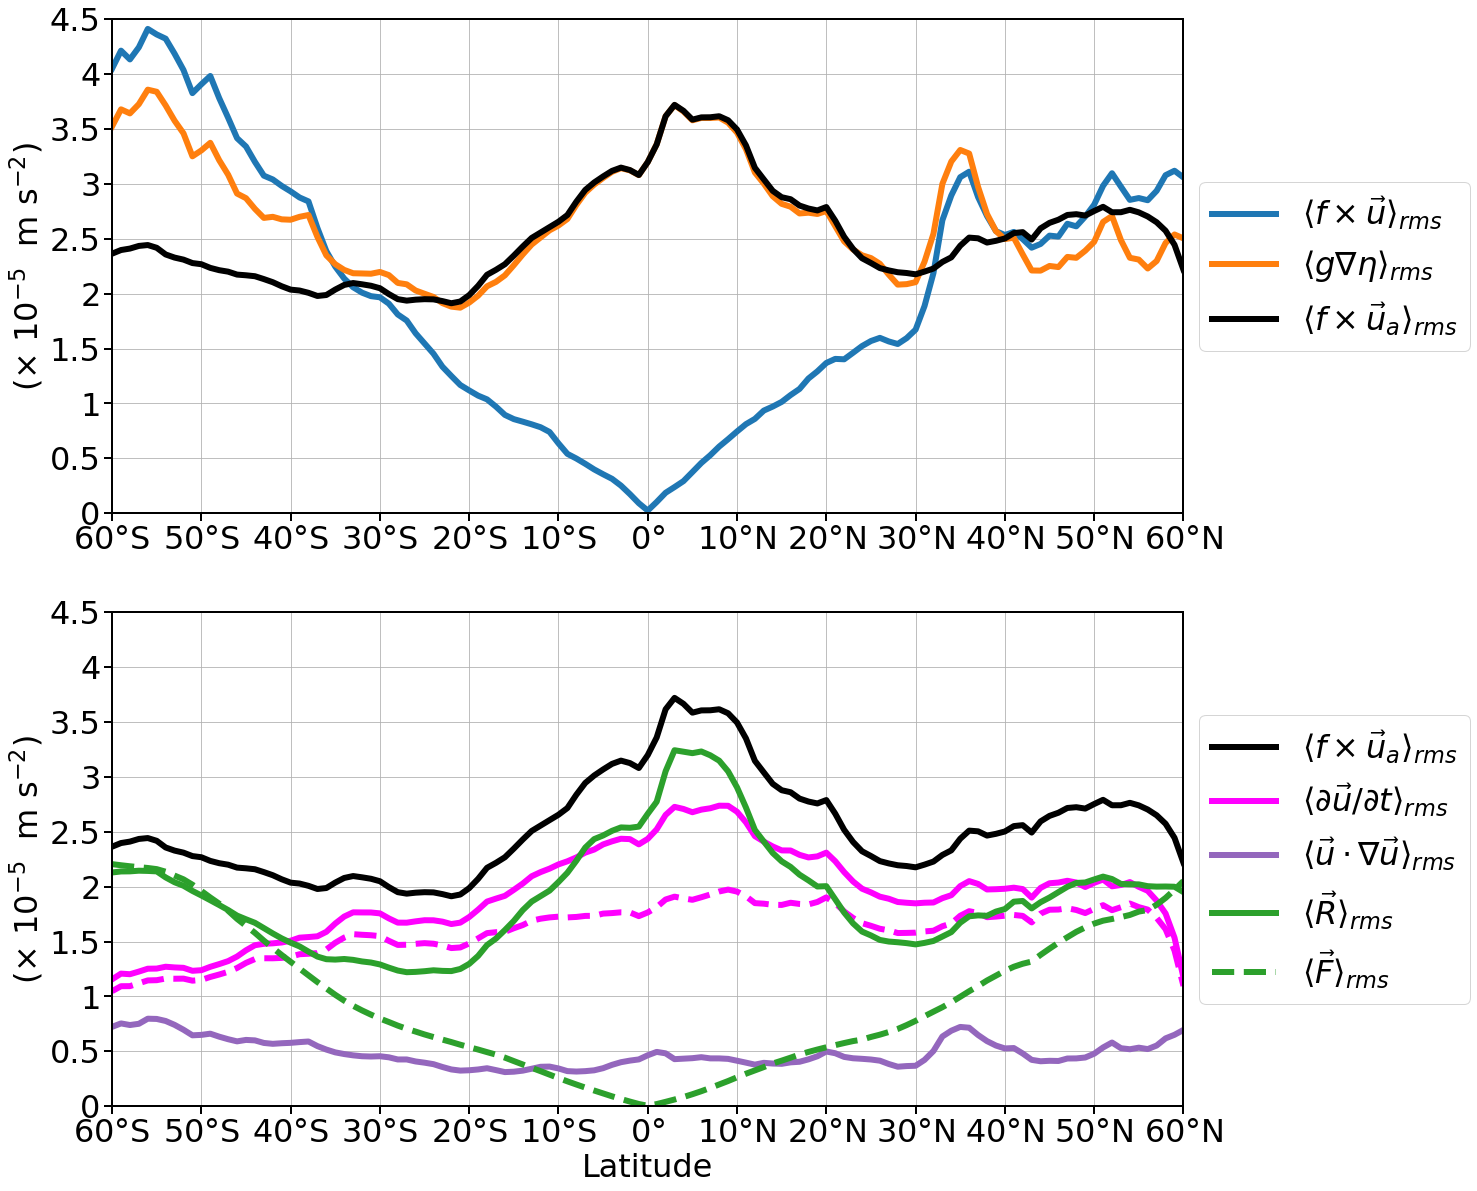

In [35]:
font_size=32
linewidth=6

fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(211)
linear_corilis_zonmean.plot(label=r'$\langle f \times \vec{u} \rangle_{rms}$', linewidth=linewidth, color="tab:blue") 
pressure_gradient_zonmean.where(np.isfinite(pressure_gradient_zonmean), drop=True).plot(label=r'$\langle g\nabla\eta \rangle_{rms}$', linewidth=linewidth, color="tab:orange") 
f_ageo_zonmean.where(np.isfinite(f_ageo_zonmean), drop=True).plot(label=r'$\langle f \times \vec{u}_a \rangle_{rms}$', linewidth=linewidth, color="black") 
ax.grid()
# x,y ticks
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50,60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_ylim([0,4.5e-5])
ax.set_yticks([0,0.5e-5,1e-5,1.5e-5,2e-5,2.5e-5,3e-5,3.5e-5,4e-5,4.5e-5])
ax.set_yticklabels(['0','0.5','1','1.5','2','2.5','3','3.5','4','4.5'])
# Label, size
ax.set_xlabel('',fontsize=font_size)
ax.set_ylabel(r'($\times$ 10$^{-5}$  m s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


ax = plt.subplot(212)
f_ageo_zonmean.where(np.isfinite(f_ageo_zonmean), drop=True).plot(label=r'$\langle f \times \vec{u}_a \rangle_{rms}$', linewidth=linewidth, color="black") 
accerlation_normalised_zonmean.plot(label=r'$\langle \partial \vec{u}/\partial t \rangle_{rms}$', linewidth=linewidth, color="magenta") 
accerlation_normalised_zonmean_2hours.plot(label='', linewidth=linewidth, color="magenta", linestyle='--') 
nonlinear_advection_normalised_zonmean.where(np.isfinite(nonlinear_advection_normalised_zonmean), drop=True).plot(label=r'$\langle \vec{u} \cdot \nabla \vec{u} \rangle_{rms}$', linewidth=linewidth, color="tab:purple") 
residuals_normalised_zonmean.where(np.isfinite(residuals_normalised_zonmean), drop=True).plot(label=r'$\langle \vec{R}  \rangle_{rms}$', linewidth=linewidth, color="tab:green") 
(2.5*Tau_ELD_normalised_zonmean).plot(label=r'$\langle \vec{F}  \rangle_{rms}$', linewidth=linewidth, color="tab:green", linestyle='--') 
#(accerlation_normalised_zonmean+nonlinear_advection_normalised_zonmean+residuals_normalised_zonmean).plot(label=r'$\langle \partial \vec{u}/\partial t \rangle_{rms} +  \langle \vec{u} \cdot \nabla \vec{u} \rangle_{rms} + \langle \vec{F}  \rangle_{rms}$', linewidth=linewidth, color="magenta") 
ax.grid()
# x,y ticks
ax.set_xlim(-60, 60)
ax.set_xticks([-60,-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50,60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_ylim([0,4.5e-5])
#ax.set_yticks([0,1e-5,2e-5,3e-5,4e-5,5e-5])
ax.set_yticks([0,0.5e-5,1e-5,1.5e-5,2e-5,2.5e-5,3e-5,3.5e-5,4e-5,4.5e-5])
ax.set_yticklabels(['0','0.5','1','1.5','2','2.5','3','3.5','4','4.5'])
#ax.set_yticklabels(['0','','1','','2','','3','','4','','5'])
# Label, size
ax.set_xlabel('Latitude',fontsize=font_size)
ax.set_ylabel(r'($\times$ 10$^{-5}$  m s$^{-2}$)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': font_size})
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
#plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_9_0131.png')

In [38]:
cluster.close()